## Import packages

In [30]:
import pickle
import numpy as np
import math
import tensorflow as tf

### Plot graphs inline

In [31]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

### Load and pre-process the dataset

The CIFAR-10 dataset consists of 5 batches, named data_batch_1, data_batch_2, etc.. Each batch contains the labels and images of the following:

* 0 - airplane
* 1 - automobile
* 2 - bird
* 3 - cat
* 4 - deer
* 5 - dog
* 6 - frog
* 7 - horse
* 8 - ship
* 9 - truck


* Access the image and the labels from a single batch specified by id (1-5) and combine them 
* Reshape the images, the images are fed to the convolutional layer as a 4-D tensor.
* Transpose the axes of the reshaped image to be in this form: *[batch_size, height, width, channels]*, **channels should be the last axis**

In [32]:
features = np.empty((0, 32,32,3))
labels = []

In [33]:
for i in range(5):
    with open('cifar_10/data_batch_'+str(i+1), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    new_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    features=np.append(features,new_features,axis=0)
    new_labels = batch['labels']
    labels.extend(new_labels)

### Explore the data
* Map the integer labels to the actual labels for display
* Plot the image

In [34]:
features.shape

(50000, 32, 32, 3)

In [35]:
len(labels)

50000

In [36]:
classes = ['airplane', 
          'automobile', 
          'bird', 
          'cat', 
          'deer', 
          'dog', 
          'frog', 
          'horse', 
          'ship', 
          'truck']

Label:  bird


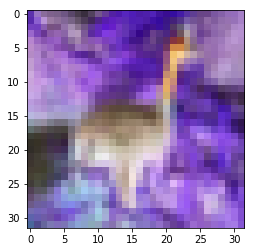

In [37]:
print("Label: ", classes[labels[6]])
plt.imshow(features[6])

### Split the dataset into training and test sets


In [38]:
train_size = int(len(features) * 0.8)

In [39]:
X_train = features[:train_size,:,:]

y_train = labels[:train_size]

X_test = features[train_size:,:,:]

y_test = labels[train_size:]

In [40]:
print(X_train.shape)
print(X_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [41]:
print(len(y_train))
print(len(y_test))

40000
10000


### Defining parameters

* Each image is of size 32x32
* The image is RGB so has 3 channels, and requires 3 numbers to represent each pixel
* The training dataset placeholder can have any number of instances and each instance is an array of 32x32 pixels.
* The images are fed to the convolutional layer as a 4D tensor *[batch_size, height, width, channels]*

In [42]:
height = 32
width = 32
channels = 3
n_inputs = height * width

In [43]:
tf.reset_default_graph()

In [44]:
X = tf.placeholder(tf.float32, shape=[None,  height, width, channels], name="X")

### Add a dropout layer to avoid overfitting the training data

* The training flag is set to False during prediction and is True while training (dropout is applied only in the training phase)
* The dropout_rate indicates the chances that a neuron is turned off during training

In [45]:
dropout_rate = 0.4

training = tf.placeholder_with_default(False, shape=(), name='training')
dropOut_1 = tf.layers.dropout(X, dropout_rate, training=training)

In [46]:
y = tf.placeholder(tf.int32, shape=[None], name="y")

### Neural network design

* 2 convolutional layers
* 1 max pooling layer : The pooled image is only 1/4th the size of the original image with this kernel size and stride
* 1 convolutional layer
* 1 max pooling layer
* flatten : Reshape the pooled layer to be a 1-D vector
* 2 fully connected layers
* Output layer : The number of outputs of the logits layer should be 10 as cifar has 10 classes of data.
* apply the softmax activation as well as calculate the cross-entropy as our cost function

In [47]:
conv_1 = tf.layers.conv2d(dropOut_1, filters=32,
                         kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="conv1")

In [48]:
conv_2 = tf.layers.conv2d(conv_1, filters=64, 
                         kernel_size=3,
                         strides=2, padding="SAME",
                         activation=tf.nn.relu, name="conv2")

In [49]:
pool_3 = tf.nn.max_pool(conv_2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding="VALID")

In [50]:
conv_4 = tf.layers.conv2d(pool_3, filters=128, 
                         kernel_size=4,
                         strides=3, padding="SAME",
                         activation=tf.nn.relu, name="conv4")

In [51]:
pool_5 = tf.nn.max_pool(conv_4,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 1, 1, 1],
                       padding="VALID")

pool_5_flat = tf.reshape(pool_5, shape=[-1, 128 * 2 * 2])

In [52]:
fullyconn_1 = tf.layers.dense(pool_5_flat, 128,
                             activation=tf.nn.relu, name="fc1")

In [53]:
fullyconn_2 = tf.layers.dense(fullyconn_1, 64,
                             activation=tf.nn.relu, name="fc2")

In [54]:
output = tf.layers.dense(fullyconn_2, 10, name="output")

In [55]:
x_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output,
                                                          labels=y)
loss = tf.reduce_mean(x_entropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

### Evaluating the model

* Check whether the highest probability output is equal to the y-label
* Check the accuracy across all predictions

In [56]:
correct = tf.nn.in_top_k(output, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [57]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Train the model

* Ensure that dropout is enabled during training to avoid overfitting
* Train on all the batches for more accuarcy

In [58]:
n_epochs = 10

_BATCH_SIZE = 128

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        batch_size = int(math.ceil(len(X_train) / _BATCH_SIZE))
        for s in range(batch_size):
            batch_xs = X_train[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]
            batch_ys = y_train[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]

            sess.run(training_op, feed_dict={X: batch_xs, y: batch_ys , training: True})

        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)


0 Train accuracy: 0.215075 Test accuracy: 0.2114
1 Train accuracy: 0.327275 Test accuracy: 0.3154
2 Train accuracy: 0.425875 Test accuracy: 0.4145
3 Train accuracy: 0.431075 Test accuracy: 0.4159
4 Train accuracy: 0.470025 Test accuracy: 0.4489
5 Train accuracy: 0.470725 Test accuracy: 0.4482
6 Train accuracy: 0.497375 Test accuracy: 0.4715
7 Train accuracy: 0.52245 Test accuracy: 0.4977
8 Train accuracy: 0.54285 Test accuracy: 0.5067
9 Train accuracy: 0.547925 Test accuracy: 0.5101
